In [71]:
%pip install -U matplotlib


     ---------------------------------------- 0.0/104.0 kB ? eta -:--:--
     --- ------------------------------------ 10.2/104.0 kB ? eta -:--:--
     ------------------------------ -------- 81.9/104.0 kB 1.6 MB/s eta 0:00:01
     ------------------------------------ 104.0/104.0 kB 749.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
    --------------------------------------- 0.1/8.0 MB ? eta -:--:--
   -- ------------------------------------- 0.4/8.0 MB 6.3 MB/s eta 0:00:02
   --- ------------------------------------ 0.7/8.0 MB 6.0 MB/s eta 0:00:02
   ---- ----------------------------------- 0.9/8.0 MB 5.9 MB/s eta 0:00:02
   ------- -------------------------------- 1.5/8.0 MB 6.6 MB/s eta 0:00:01
   --------- ------------------------------ 1.9/8.0 MB 7.1 MB/s eta 0:00:01
   ------------ --------------------------- 2.5/8.0 MB 7.9 MB/s eta 0:00:01
   ---------------- ----------------------- 3.3/8.0 MB 8.8 MB/s eta 0:00:01
   -------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Newton raphson

In [1]:
import torch
from torch.autograd.functional import hessian
def newton_raphson(fn, start_point=torch.tensor([0.1],
                                            dtype=float, 
                                            requires_grad=True),
                                            epsilon = 0.01,
                                            iterations = 100):
    iter = 1
    lambda_regularization_var = 1e-4
    while iter <= iterations + 1:
        print(f"iteration number -> {iter}")
        f_val = fn(start_point)
        f_val.backward()
        gradient = start_point.grad
        print(f"gradient = {torch.norm(gradient)}")
        if torch.norm(gradient) <= epsilon:
            print(f"Since norm of the gradient {torch.norm(gradient)} is less than epsilon {epsilon} , new optimal point = {start_point}")
            return gradient, start_point
        hessian_matrix = hessian(fn, start_point)
        print(f"hessian matrix = {hessian_matrix}")
        if torch.det(hessian_matrix) == 0:
            print(f"hessian matrix {hessian_matrix} cannot be inverted ,so either perform H + lambda*I or moore penrose psuedo inverse")
            modified_hessian_matrix = hessian_matrix + lambda_regularization_var*torch.eye(hessian_matrix.shape[0],dtype=float)
            # step_size = - torch.matmul(torch.inverse(modified_hessian_matrix), gradient)
            # moore penrose psuedo inverse
            step_size = - torch.matmul(torch.pinverse(hessian_matrix), gradient)
            print(f"step size after moore penrose psuedo inverse = {step_size}")
        else:
            step_size = - torch.matmul(torch.inverse(hessian_matrix), gradient)
        print(f"step_size = {step_size}")
        start_point = start_point + step_size
        print(f"new start point = {start_point}")
        start_point = start_point.detach().clone().requires_grad_(True)
        print(f"\n-------iteration {iter} finished--------\n")
        iter += 1
    print(f"no convergence observed after {iter} iterations")
    return gradient, start_point
    
    
    
    

In [2]:
def trig(v):
    x = v
    return 0.65 - 0.75 / (1 + x**2) - 0.65 * x * torch.atan(1 / (x))
g,s = newton_raphson(fn=trig)

iteration number -> 1
gradient = 0.744832145242825
hessian matrix = tensor([[2.6866]], dtype=torch.float64)
step_size = tensor([0.2772], dtype=torch.float64)
new start point = tensor([0.3772], dtype=torch.float64, grad_fn=<AddBackward0>)

-------iteration 1 finished--------

iteration number -> 2
gradient = 0.1382308799269682
hessian matrix = tensor([[1.5730]], dtype=torch.float64)
step_size = tensor([0.0879], dtype=torch.float64)
new start point = tensor([0.4651], dtype=torch.float64, grad_fn=<AddBackward0>)

-------iteration 2 finished--------

iteration number -> 3
gradient = 0.017907281847109324
hessian matrix = tensor([[1.1713]], dtype=torch.float64)
step_size = tensor([0.0153], dtype=torch.float64)
new start point = tensor([0.4804], dtype=torch.float64, grad_fn=<AddBackward0>)

-------iteration 3 finished--------

iteration number -> 4
gradient = 0.000503475857801694
Since norm of the gradient 0.000503475857801694 is less than epsilon 0.01 , new optimal point = tensor([0.4804], d

In [3]:
def fun(v):
    x, y, z = v
    return 2*x**2 + 2*x*y + z + 3*y**2

g, s = newton_raphson(fn=fun,
                      start_point=torch.tensor([1,-2,3], 
                                               dtype=float, 
                                               requires_grad=True),
                      epsilon=0,
                      iterations=100
                      )

iteration number -> 1
gradient = 10.04987562112089
hessian matrix = tensor([[4., 2., 0.],
        [2., 6., 0.],
        [0., 0., 0.]], dtype=torch.float64)
hessian matrix tensor([[4., 2., 0.],
        [2., 6., 0.],
        [0., 0., 0.]], dtype=torch.float64) cannot be inverted ,so either perform H + lambda*I or moore penrose psuedo inverse
step size after moore penrose psuedo inverse = tensor([-1.0000,  2.0000, -0.0000], dtype=torch.float64)
step_size = tensor([-1.0000,  2.0000, -0.0000], dtype=torch.float64)
new start point = tensor([ 2.2204e-16, -4.4409e-16,  3.0000e+00], dtype=torch.float64,
       grad_fn=<AddBackward0>)

-------iteration 1 finished--------

iteration number -> 2
gradient = 1.0
hessian matrix = tensor([[4., 2., 0.],
        [2., 6., 0.],
        [0., 0., 0.]], dtype=torch.float64)
hessian matrix tensor([[4., 2., 0.],
        [2., 6., 0.],
        [0., 0., 0.]], dtype=torch.float64) cannot be inverted ,so either perform H + lambda*I or moore penrose psuedo inverse
s

## Steepest descent method

In [4]:
import torch 
import torch.optim as optim
def find_alpha(fn,
                starting_point,
                d,
                learning_rate=1e-3,
                max_iterations=100,
                tolerance=0):
    print(f"finding alpha for direction {d}")
    alpha = torch.tensor(0.0, dtype=torch.float, requires_grad=True)
    optimizer = optim.Adam([alpha], lr=learning_rate)
    
    iteration = 0
    prev_point = starting_point.clone().detach()  

    while iteration <= max_iterations:
        optimizer.zero_grad()
        
        current_point = starting_point + alpha * d
        function_value = fn(current_point)
        
        function_value.backward()
        
        if alpha.grad is not None:
            grad_norm = torch.norm(alpha.grad).item()
        else:
            grad_norm = float('inf')
        
        point_difference = torch.norm(current_point - prev_point).item()
        
        optimizer.step()
        
        if iteration % 100 == 0 or iteration == max_iterations:
            print(f"Iteration {iteration}:")
            print(f"Alpha: {alpha.item():.6f}")
            print(f"Function value: {function_value.item():.6f}")
            print(f"Point difference: {point_difference:.8f}")
            print(f"Gradient norm: {grad_norm:.8f}\n")
        
        if point_difference <= tolerance and grad_norm <= tolerance:
            print(f"Converged at iteration {iteration}")
            break
        with torch.no_grad():
            prev_point.copy_(current_point)

        iteration += 1
    
    return alpha.item()
    
def steepest_descent(fn, iterations=100, 
                     tolerance=1e-5, 
                     starting_point=torch.tensor([1, -2, 3], 
                                                 dtype=float, 
                                                 requires_grad=True)):
    iteration_count = 0
    prev_point = starting_point.clone().detach()
    while iteration_count <= iterations:
        print(f"starting iteration {iteration_count}.....")
        f_value = fn(starting_point)
        f_value.backward()
        gradient = starting_point.grad
        direction = -gradient
        alpha = find_alpha(fn=fn, 
                           starting_point=starting_point, 
                           d=direction)
        
        print(f"Direction is {direction} \n")
        print(f"alpha is {alpha}")
        starting_point = starting_point + alpha * direction
        print(f"new starting point  = {starting_point}")
        if abs(fn(starting_point).item() - fn(prev_point).item()) <= tolerance:
            print(f"Converged at iteration {iteration_count}")
            break
        prev_point.copy_(starting_point.detach())
        starting_point = starting_point.detach().clone().requires_grad_(True)
        print(f"Iteration {iteration_count} finished \n")
        print(100*"*")
        print("\n\n")
        iteration_count += 1
    print(f"No convergence after {iteration_count}")
    return starting_point

In [5]:
def fn(v):
    x,y,z = v
    return 2*x**2 + 2*x*y + z + 3*y**2
starting_point = steepest_descent(fn=fn)

    

starting iteration 0.....
finding alpha for direction tensor([-0., 10., -1.], dtype=torch.float64)
Iteration 0:
Alpha: 0.001000
Function value: 13.000000
Point difference: 0.00000000
Gradient norm: 101.00000000

Iteration 100:
Alpha: 0.088685
Function value: 6.436088
Point difference: 0.00710834
Gradient norm: 48.21105576

Direction is tensor([-0., 10., -1.], dtype=torch.float64) 

alpha is 0.0886850357055664
new starting point  = tensor([ 1.0000, -1.1131,  2.9113], dtype=torch.float64,
       grad_fn=<AddBackward0>)
Iteration 0 finished 

****************************************************************************************************



starting iteration 1.....
finding alpha for direction tensor([-1.7737,  4.6789, -1.0000], dtype=torch.float64)
Iteration 0:
Alpha: 0.001000
Function value: 6.402322
Point difference: 0.00000000
Gradient norm: 26.03809929

Iteration 100:
Alpha: 0.092608
Function value: 4.478505
Point difference: 0.00409162
Gradient norm: 15.87113571

Direction is te

### Conjugate gradient method

In [6]:
import torch 
import torch.optim as optim
# def find_alpha(fn, starting_point, d, max_iterations=100, tolerance=1e-6):
#     """
#     Finds the optimal step size alpha using differentiation.
    
#     Parameters:
#     - fn: The function to minimize.
#     - starting_point: The current position (tensor).
#     - d: The search direction (tensor).
#     - max_iterations: Number of iterations for convergence.
#     - tolerance: Convergence threshold for alpha derivative.

#     Returns:
#     - alpha (optimal step size).
#     """
#     # Initialize alpha as a trainable tensor
#     alpha = torch.tensor(0.0, dtype=torch.float, requires_grad=True)

#     optimizer = torch.optim.Adam([alpha], lr=0.1)  # Adam optimizer for fast convergence

#     for _ in range(max_iterations):
#         optimizer.zero_grad()
        
#         # Compute function value at new point
#         new_point = starting_point + alpha * d
#         function_value = fn(new_point)

#         # Compute derivative w.r.t. alpha
#         function_value.backward()

#         grad_norm = torch.abs(alpha.grad).item()  # Get gradient magnitude

#         if grad_norm <= tolerance:  # Check convergence
#             break

#         optimizer.step()  # Update alpha

#     return alpha.item() 
def find_alpha(fn, starting_point, d):
    x_k, y_k = starting_point
    d_x, d_y = d
    numerator = - (3 * d_x * x_k + d_y * y_k - d_x * y_k - d_y * x_k + 2 * d_x)
    denominator = (3 * d_x**2 + d_y**2 - 2 * d_x * d_y)
    if torch.abs(denominator) < 1e-10:  # Prevent division by zero
        return 1.0  # Default step size
    return (numerator / denominator).item()
def conjugate_gradient_method(fn,
                              max_iterations=100,
                              tolerance=1e-2,
                              starting_point=torch.tensor([-2, 4], dtype=torch.float, requires_grad=True),
                              ):
    iter_count = 0
    previous_direction = None
    previous_gradient = None
    while iter_count <= max_iterations:
        print(f"Starting iteration {iter_count} .......")
        print(f"Starting point = {starting_point.tolist()}")
        if starting_point.grad is not None:
            starting_point.grad.zero_()  
        value = fn(starting_point)
        value.backward()  
        gradient = starting_point.grad.clone()  
        print(f"gradient norm = {torch.norm(gradient).item()}")
        if torch.norm(gradient).item() <= tolerance:
            print(f"Converged at iteration {iter_count}: Optimal point = {starting_point.tolist()}")
            break
        if iter_count == 0:
            direction = -gradient
        else:
            beta = (torch.norm(gradient) ** 2) / (torch.norm(previous_gradient) ** 2)
            direction = -gradient + beta * previous_direction
        print(f"Calculated direction = {direction.tolist()}")
        alpha = find_alpha(fn=fn, starting_point=starting_point, d=direction)
        if alpha is None or torch.isnan(torch.tensor(alpha)):
            print("Alpha is NaN or None! Skipping update...")
            break
        alpha = torch.tensor(alpha, dtype=torch.float)  # Ensure alpha is a tensor
        print(f"Calculated step size = {alpha.item():.6f}")
        previous_direction = direction.clone()
        previous_gradient = gradient.clone()
        with torch.no_grad():
            starting_point.add_(alpha * direction)  # Update value
        starting_point.requires_grad_(True)  # Ensure gradient tracking is ON
        print(f"Iteration {iter_count} finished ...")
        print(100 * "*")
        iter_count += 1
    return starting_point
    
    
    

In [7]:
# def fn(v):
    
#     x,y = v
    
#     return x - y + 2*x**2 + 2*x*y + y**2

def fn(v):
    x,y = v
    return (3/2)*x**2 + (1/2)*y**2 -x*y + 2*x

starting_point = conjugate_gradient_method(fn=fn)

Starting iteration 0 .......
Starting point = [-2.0, 4.0]
gradient norm = 10.0
Calculated direction = [8.0, -6.0]
Calculated step size = 0.308642
Iteration 0 finished ...
****************************************************************************************************
Starting iteration 1 .......
Starting point = [0.46913576126098633, 2.1481480598449707]
gradient norm = 2.0987653732299805
Calculated direction = [-0.9068739414215088, -1.9433012008666992]
Calculated step size = 1.620000
Iteration 1 finished ...
****************************************************************************************************
Starting iteration 2 .......
Starting point = [-0.9999997615814209, -0.9999995231628418]
gradient norm = 3.3717478231665154e-07
Converged at iteration 2: Optimal point = [-0.9999997615814209, -0.9999995231628418]


In [8]:
a = torch.tensor([1,-1/2], dtype=torch.float64)
Q = torch.tensor([[1, 2], [2, 8]], dtype=torch.float64)
b = torch.tensor([1,0], dtype=torch.float64)

In [9]:
result = torch.matmul(a.T, torch.matmul(Q, b))
print(result)

tensor(0., dtype=torch.float64)


C:\Users\Z004UAHC\AppData\Local\Temp\ipykernel_13264\3224076811.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3679.)
  result = torch.matmul(a.T, torch.matmul(Q, b))


In [10]:
result.item()

0.0

In [19]:
a = torch.tensor([0,0,-5], dtype=torch.float64)
Q = torch.tensor([[2,-2,0], [-2, 3, -1], [0, -1, 6]], dtype=torch.float64)
b = torch.tensor([0,0,-5], dtype=torch.float64)

In [20]:
torch.matmul(a.T, torch.matmul(Q,b))

tensor(150., dtype=torch.float64)

In [13]:
result = torch.matmul(a.T, torch.matmul(Q, b))
print(result)

tensor(0., dtype=torch.float64)


In [11]:
def gram_schmidt_conjugate(Q, n):
    # Initialize random vectors
    D = torch.randn(n, n, dtype=torch.float64)
    
    # First direction can be random (normalized)
    D[:, 0] = D[:, 0] / torch.norm(D[:, 0])
    
    # Generate conjugate directions
    for i in range(1, n):
        v = D[:, i]
        # Make it conjugate to all previous vectors
        for j in range(i):
            # Conjugate Gram-Schmidt projection
            d_j = D[:, j]
            numerator = torch.dot(v, Q @ d_j)
            denominator = torch.dot(d_j, Q @ d_j)
            v = v - (numerator/denominator) * d_j
        
        # Normalize the vector
        D[:, i] = v / torch.norm(v)
    
    return D

In [12]:
D = gram_schmidt_conjugate(Q,3)

RuntimeError: size mismatch, got input (2), mat (2x2), vec (3)

In [18]:
torch.matmul(a.T, torch.matmul(Q,D))

tensor([-25.7044,  -2.8905,   0.8822], dtype=torch.float64)

### Fibonacci search method

In [10]:
import pandas as pd
import numpy as np

def fibonacci(n): # define the  function
    fn = [0, 1,]
    for i in range(2, n+1):
        fn.append(fn[i-1] + fn[i-2])
    return fn


N = np.arange(16)
data = {'n': N, 'Fibonacci(n)': fibonacci(15)}
df = pd.DataFrame(data)


def fib_search(f, xl, xr, n):
    F = fibonacci(n) # Call the fibonnaci number function
    L0 = xr - xl # Initial interval of uncertainty
    R1 = L0 # Initial Reduction Ratio
    Li = (F[n-2]/F[n])*L0 
    
    R = [Li/L0]

    for i in range(2, n+1):
        if Li > L0/2:
            x1 = xr - Li
            x2 = xl + Li
        else:
            x1 = xl + Li
            x2 = xr - Li
            
        f1, f2 = f(x1), f(x2)
        
        if f1 < f2:
            xr = x2
            Li = (F[n - i]/F[n - (i - 2)])*L0 # New interval of uncertainty
        elif f1 > f2:
            xl = x1
            Li = (F[n - i]/F[n - (i - 2)])*L0 # New interval of uncertainty
        else:
            xl, xr = x1, x2
            Li = (F[n - i]/F[n - (i - 2)])*(xr - xl) # New interval of uncertainty
            
        L0 = xr - xl
        R += [Li/R1,] # Append the new reduction ratio
        
    if f1 <= f2:
        return [x1, f(x1), R] # Final result
    else:
        return [x2, f(x2), R] # Final result

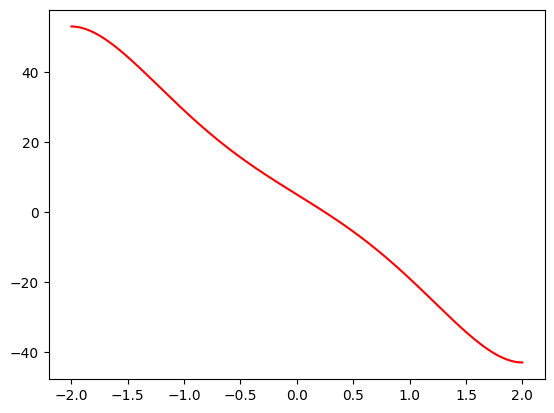

In [11]:
import matplotlib.pyplot as plt
import numpy as np
def f(x): # Objective function
    return x**5 - 5*x**3 - 20*x + 5

x = np.linspace(-2, 2, 200)
plt.plot(x, f(x), 'r-');

In [16]:
f(1.64)

-37.9910450176

Text(0, 0.5, 'f(x)')

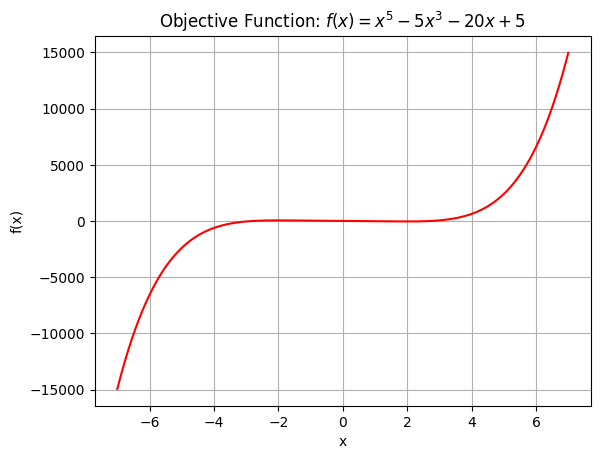

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def f(x):
    return x**5 - 5*x**3 - 20*x + 5

x = np.linspace(-7, 7, 1000)
plt.plot(x, f(x), 'r-')
plt.grid(True)
plt.title('Objective Function: $f(x) = x^5 - 5x^3 - 20x + 5$')
plt.xlabel('x')
plt.ylabel('f(x)')

In [18]:
Fib = fib_search(f, -2, 2, 25)
x_star, f_x_star, R = Fib
print ("x*:", x_star)

x*: 1.9999466844385205


In [19]:
print ("f(x*):", f_x_star)

f(x*): -42.99999985787785


In [12]:

def fib_search(f, xl, xr, n):    
    F = fibonacci(n)
    L0 = xr - xl
    ini = L0
    Li = (F[n-2]/F[n])*L0
    
    R = [Li/L0]
    a = [xl]
    b = [xr]
    F1 = [f(xl)]
    F2 = [f(xr)]

    for i in range(2, n+1):
        #print("reduction ratio:", Li/ini)
        if Li > L0/2:
            x1 = xr - Li
            x2 = xl + Li
        else:
            x1 = xl + Li
            x2 = xr - Li
            
        f1, f2 = f(x1), f(x2)
        
        if f1 < f2:
            xr = x2
            Li = (F[n - i]/F[n - (i - 2)])*L0
        elif f1 > f2:
            xl = x1
            Li = (F[n - i]/F[n - (i - 2)])*L0
        else:
            xl, xr = x1, x2
            Li = (F[n - i]/F[n - (i - 2)])*(xr - xl)
            
        L0 = xr - xl
        R += [Li/ini,] 
        a += [xl, ]
        b += [xr, ]
        F1 += [f1, ]
        F2 += [f2, ]
        
    data = {'n' : range(0, n),
            'xl': a,
            'xr': b,
            'f(x1)': F1,
            'f(x2)': F2,
            'Reduction Ratio': R}

    df = pd.DataFrame(data, columns = ['n', 'xl', 'xr', 'f(x1)', 'f(x2)', 'Reduction Ratio'])
    return df

df = fib_search(f, -2.5, 2.5, 25)

In [13]:
df = fib_search(f, -2, 2, 7)

In [14]:
df

,n,xl,xr,f(x1),f(x2),Reduction Ratio
0,0,-2.000000,2.000000,53.000000,-43.000000,0.384615
1,1,-0.461538,2.000000,14.701406,-4.701406,0.384615
2,2,0.461538,2.000000,-4.701406,-21.334825,0.230769
3,3,1.076923,2.000000,-21.334825,-30.875796,0.153846
4,4,1.384615,2.000000,-30.875796,-39.198970,0.076923
5,5,1.692308,1.692308,-39.198970,-39.198970,0.000000
6,6,1.692308,1.692308,-39.198970,-39.198970,0.000000


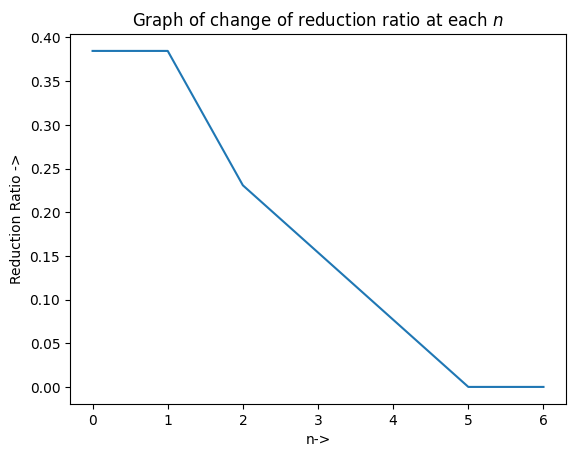

In [15]:
plt.xlabel("n->")
plt.ylabel("Reduction Ratio ->")
plt.plot(range(0, len(df)), df['Reduction Ratio'])
plt.title("Graph of change of reduction ratio at each $n$")
plt.show()

### show that local minima exists at a given point

In [16]:
def f(v):
    x,y = v
    return x**4 + y**4 + 4*x - 32*y -7

import torch

point = torch.tensor([-1,2], dtype=torch.float64, requires_grad=True)

f_val = f(point)
f_val.backward()

In [25]:
point.grad

tensor([0., 0.], dtype=torch.float64)

### Quasi newton (DFP)

In [17]:
import numpy as np

import matplotlib.pyplot as plt

def f(v):
    x, y = v
    return 100 * (y - x**2)**2 + (1 - x)**2

def dfp_quasi_newton(fn, start_point, epsilon=1e-5, max_iterations=100):
    n = len(start_point)
    B = torch.eye(n, dtype=torch.float64)  # Initialize B as identity matrix
    x = start_point.clone().detach().requires_grad_(True)
    
    for i in range(max_iterations):
        f_val = fn(x)
        f_val.backward()
        grad = x.grad.clone().detach()
        
        print(f"Iteration {i}:")
        print(f"Start point: {x.tolist()}")
        print(f"Gradient: {grad.tolist()}")
        
        if torch.norm(grad) < epsilon:
            print(f"Converged at iteration {i}")
            break
        
        p = -torch.matmul(B, grad)
        x_new = x + p
        x_new = x_new.clone().detach().requires_grad_(True)
        
        f_val_new = fn(x_new)
        f_val_new.backward()
        grad_new = x_new.grad.clone().detach()
        
        s = (x_new - x).view(-1, 1)
        y = (grad_new - grad).view(-1, 1)
        
        Bs = torch.matmul(B, s)
        sBs = torch.matmul(s.T, Bs)
        
        B = B + (torch.matmul(y, y.T) / torch.matmul(y.T, s)) - (Bs @ Bs.T / sBs)
        
        x = x_new.clone().detach().requires_grad_(True)
        
        print(f"Iteration {i} finished: x = {x.tolist()}, f(x) = {f_val.item()}")
        print(100 * "-")
    
    return x

start_point = torch.tensor([-1.2, 1.0], dtype=torch.float64, requires_grad=True)
optimal_point = dfp_quasi_newton(f, start_point)
print(f"Optimal point: {optimal_point.tolist()}")





Iteration 0:
Start point: [-1.2, 1.0]
Gradient: [-215.59999999999997, -87.99999999999999]
Iteration 0 finished: x = [214.39999999999998, 88.99999999999999], f(x) = 24.199999999999996
----------------------------------------------------------------------------------------------------
Iteration 1:
Start point: [214.39999999999998, 88.99999999999999]
Gradient: [3934528580.399999, -9175671.999999998]
Iteration 1 finished: x = [-7.187082457230663e+16, 167608947402000.7], f(x) = 210482437168.51993
----------------------------------------------------------------------------------------------------
Iteration 2:
Start point: [-7.187082457230663e+16, 167608947402000.7]
Gradient: [-1.4849706633277433e+53, -1.0330830849406549e+36]
Iteration 2 finished: x = [3.068196147833982e+89, 2.134521320780994e+72], f(x) = 2.6681516509762513e+69
----------------------------------------------------------------------------------------------------
Iteration 3:
Start point: [3.068196147833982e+89, 2.13452132078099

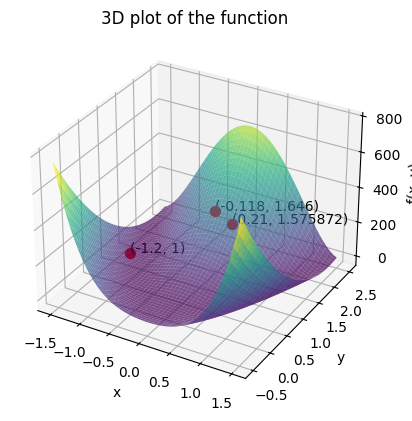

In [27]:
from mpl_toolkits.mplot3d import Axes3D

def f(v):
    x, y = v
    return 100 * (y - x**2)**2 + (1 - x)**2

# Define the range for x and y
x = np.linspace(-1.5, 1.5, 400)
y = np.linspace(-0.5, 2.5, 400)
X, Y = np.meshgrid(x, y)
Z = f([X, Y])

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)  # Set alpha for transparency

# Points to mark
points = [(-1.2, 1), (0.210, 1.575872), (-0.118, 1.646)]
for point in points:
    ax.scatter(point[0], point[1], f(point), color='r', s=50)  # Change color to red for visibility
    ax.text(point[0], point[1], f(point), f'({point[0]}, {point[1]})', color='black')  # Add text labels

ax.set_title('3D plot of the function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')

plt.show()


In [96]:
starting_point = torch.tensor([-0.11803,1.64676], dtype=torch.float64, requires_grad= True)
f_val = f(starting_point)
f_val.backward()
print(starting_point.grad)
# identity_matrix = torch.eye(len(starting_point.grad), dtype=torch.float64)
# print(identity_matrix)

tensor([ 74.8531, 326.5658], dtype=torch.float64)


In [70]:
d1 = torch.matmul(identity_matrix,-starting_point.grad)

In [73]:
d1

tensor([215.6000,  88.0000], dtype=torch.float64)

In [86]:
x = torch.tensor([-215.6, -88.0],dtype=torch.float64)
y = torch.tensor([-130.2488,306.3544],dtype=torch.float64)

torch.outer(x,x)

tensor([[46483.3600, 18972.8000],
        [18972.8000,  7744.0000]], dtype=torch.float64)

In [87]:
torch.inner(x,x)

tensor(54227.3600, dtype=torch.float64)